### Classify space rocks by using Python and artificial intelligence
https://learn.microsoft.com/en-us/training/paths/classify-space-rocks-artificial-intelligence-nasa/

Date: 2024-09-17

#### Notes

In [21]:
# OSIRIS-REx website: https://www.asteroidmission.org/galleries/

# sample collection: https://curator.jsc.nasa.gov/lunar/samplecatalog/index.cfm


#### Analyze images of rocks by using artificial intelligence
https://learn.microsoft.com/en-us/training/modules/analyze-rock-images-ai-nasa/

##### Exercise - Import Python libraries into Jupyter Notebook
https://learn.microsoft.com/en-us/training/modules/analyze-rock-images-ai-nasa/2-import-ai-libraries

In [2]:
import matplotlib.pyplot as plt


In [3]:
import numpy as np


In [4]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F


In [5]:
import torchvision
from torchvision import datasets, transforms, models


In [6]:
from PIL import Image


In [7]:
# import two libraries that ensure the plots are shown inline and with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


##### Download data
Download and save the image data from the link below into 'Data' folder in the project folder

https://www.kaggle.com/datasets/ifeoyelakin/nasa-space-rocks

##### Exercise - Import and clean data from photos
https://learn.microsoft.com/en-us/training/modules/analyze-rock-images-ai-nasa/4-import-and-clean-data


In [8]:
# Tell the machine what folder contains the image data
data_dir = './Data'


In [9]:
# Read the data, crop and resize the images, split data into two groups: test and train
def load_split_train_test(data_dir, valid_size = 0.2):

    # Transform the images to train the model
    train_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])
    
    # Transform the images to test the model
    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor()
                                          ])
    
    # Create two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform= train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Get the number of images in the training folder
    num_train = len(train_data)

    # Create a list of numbers from 0 to the number of training images - 1
    # Example: For 10 images, the variable is the list [0,1,2,3,4,5,6,7,8,9]
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2 
    split = int(np.floor(valid_size * num_train))

    # Randomly shuffle the indices
    # For 10 images, an example would be that indices is now the list [2,5,4,6,7,1,3,0,9,8]
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # With the indices randomly shuffled, 
    # grab the first 20% of the shuffled indices, and store them in the training index list
    # grab the remainder of the shuffled indices, and store them in the testing index list
    # Given our example so far, this would result is:
    # train_idx is the list [2,5] 
    # test_idx is the list [4,6,7,1,3,0,9,8]
    train_idx, test_idx = indices[split:], indices[:split]

    # Create samplers to randomly grab items from the training and testing indices lists
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create loaders to load 16 images from the train and test data folders
    # Images are chosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
    
    # Return the loaders so you can grab images randomly from the training and testing data folders
    return trainloader, testloader



In [10]:
# Using the function that shuffles images,
# create a trainloader to load 20% of the images
# create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, 0.2)

# Print the type of rocks that are included in the trainloader
print(trainloader.dataset.classes)


['Basalt', 'Highland']


In [11]:
print(testloader.dataset.classes)


['Basalt', 'Highland']


##### How a computer reads a photo as an image file
https://learn.microsoft.com/en-us/training/modules/analyze-rock-images-ai-nasa/5-how-computers-read-images

##### Exercise - Display photos in Jupyter Notebook
https://learn.microsoft.com/en-us/training/modules/analyze-rock-images-ai-nasa/6-show-imported-images

In [12]:
# Transform an image into pixels and resize it
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor()])


Add code to transform and select random images

In [13]:
# Randomly select a set of images by using a similar approach as the load_split_train_test function
import torch.utils
import torch.utils.data


def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Create an iterator to iterate over the shuffled images in the test image dataset
    dataiter = iter(loader)

    # Get and return the images and labels from the iterato
    images, labels = next(dataiter)
    return images, labels


Add code to show randomly selected images

<function matplotlib.pyplot.show(close=None, block=None)>

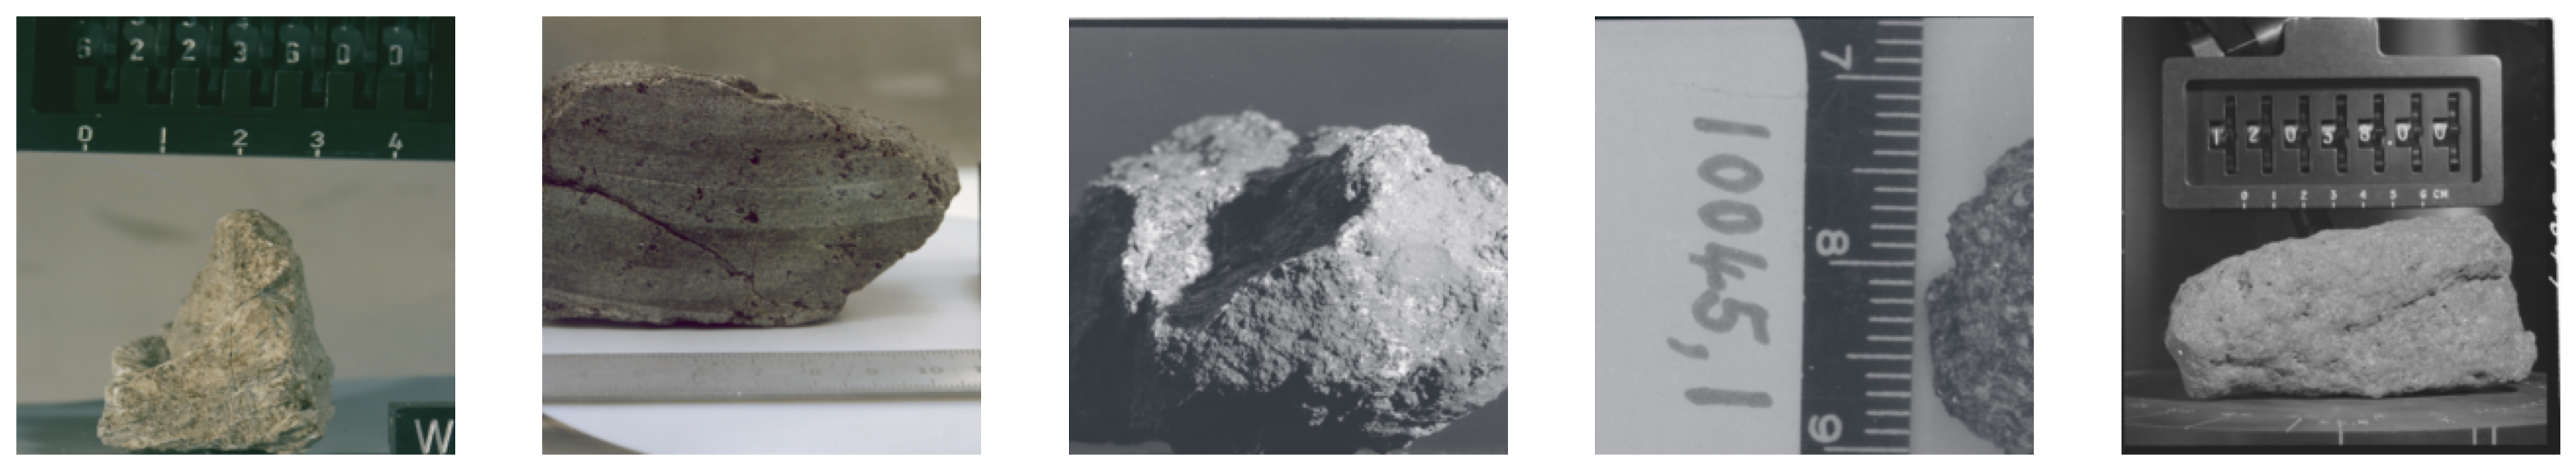

In [14]:
# Show five images - you can change this number
images, labels = get_random_images(5)

# Convert the array of pixels to an image
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# Get a list of all classes in the training data
classes = trainloader.dataset.classes

# Draw the images in a plot to display in the notebook
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

# Display all of the images
plt.show


#### Classify types of space rocks in random photos by using artificial intelligence
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/

##### Extract features from an image for AI processing
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/2-extract-features

##### Exercise - Build a neural network to classify space rocks
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/3-build-neural-network

Create a neural network

- Detect the devise type

In [18]:
from torchvision.models import resnet50, ResNet50_Weights


In [62]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = models.resnet50(pretrained=True)
model = models.resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)


#Use 'weights' instead of pretrained
# weights= ResNet50_Weights.IMAGENET1K_V1
# weights = ResNet50_Weights.IMAGENET1K_V2
# weights= ResNet50_Weights.DEFAULT -- for moset uptodate weights


Build neurons and wire the network

In [63]:
# Build all the neurons
for param in model.parameters():
    param.requires_grad = False

# Wire the neurons together to create the neural network
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 2),
                         nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Add the neural network to the device
model.to(device)

print('done')



done


##### Exercise - Train a neural network to accurately classify space rocks in photos
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/4-train-program

In [72]:
# Set the initial number of iterations to search for associations
epochs = 7
print_every = 5


In [73]:
# Initialize the loss variables
running_loss = 0
train_losses, test_losses = [], []


In [74]:
# Track the current training step, start at 0
steps = 0


In [75]:
# Search for associations in the features
for epoch in range(epochs):

    # Count each epoch
    epoch += 1

    # Load in all the image inputs and labels from the TRAIN loader
    for inputs, labels in trainloader:

        #count each training step
        steps += 1
        print('Training step', steps)

        # load the inputs and labels to the already selected device
        inputs, labels = inputs.to(device), labels.to(device)

        # zero out graiants to avoid accumulations of gradiants across training iterations
        optimizer.zero_grad()

        # pass the images through the model and return the log probabilities of each label
        logps = model.forward(inputs)

        # run the log probabilities through the criterion to get the output graph
        loss = criterion(logps, labels)

        # use the loss grah to compute gradient
        loss.backward()

        # update the parameters based on the current gradient
        optimizer.step()

        # add the actual loss number to the running loss total
        running_loss += loss.item()

        # every 5 steps, evaluate the model
        if steps % print_every == 0:

            # initialize loss and accuracy
            test_loss = 0
            accuracy = 0

            # start the model evaluation
            model.eval()

            #refine the accuracy of the prediction without updating the gradients
            with torch.no_grad():

                # load in all of the image inputs and labels from the TEST loader
                for inputs, labels in testloader:

                    # load the inputs and labels to the already selected device
                    inputs, labels = inputs.to(device), labels.to(device)

                    # pass the images through the model and return the log probabilities of each label
                    logps = model.forward(inputs)

                    # run the log probabilities through the criterion to get the output graph
                    batch_loss = criterion(logps, labels)

                    # add the actual loss number to the running loss total for the test batch
                    test_loss += batch_loss.item()

                    # return a new tensor with true probabilities 
                    ps = torch.exp(logps)

                    # return the largest probability and class of the new tensor along a given dimension
                    top_p, top_class = ps.topk(1, dim = 1)

                    # reshape the tensor to match the same shape as the top class
                    equals = top_class == labels.view(*top_class.shape)

                    # compute the accuracy and add it to the running accuracy count for the test batch
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # append the training and testing losses
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                # display the accuracy of the prediction with 3 digits in the fractional part of the decimal
                print(f'\n Epoch {epoch}/{epochs}: '
                      f'Train loss: {running_loss/print_every:.3f}.. '
                      f'Test loss: {test_loss/len(testloader):.3f}.. '
                      f'Test accuracy: {accuracy/len(testloader):.3f}\n')
                
                # train the model
                running_loss = 0
                model.train()

                # after 5 training steps, start the next epoch
                #break here in case the trainloader has remaining data
                break


Training step 1
Training step 2
Training step 3
Training step 4
Training step 5

 Epoch 1/7: Train loss: 0.088.. Test loss: 0.819.. Test accuracy: 0.740

Training step 6
Training step 7
Training step 8
Training step 9
Training step 10

 Epoch 2/7: Train loss: 0.231.. Test loss: 0.772.. Test accuracy: 0.777

Training step 11
Training step 12
Training step 13
Training step 14
Training step 15

 Epoch 3/7: Train loss: 0.195.. Test loss: 0.848.. Test accuracy: 0.808

Training step 16
Training step 17
Training step 18
Training step 19
Training step 20

 Epoch 4/7: Train loss: 0.148.. Test loss: 0.503.. Test accuracy: 0.871

Training step 21
Training step 22
Training step 23
Training step 24
Training step 25

 Epoch 5/7: Train loss: 0.251.. Test loss: 0.986.. Test accuracy: 0.840

Training step 26
Training step 27
Training step 28
Training step 29
Training step 30

 Epoch 6/7: Train loss: 0.223.. Test loss: 1.039.. Test accuracy: 0.679

Training step 31
Training step 32
Training step 33
Trai

#### Exercise - Determine the accuracy of a neural network in classifying space rocks
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/5-determine-accuracy

##### Show the model accuracy

In [76]:
print(accuracy/len(testloader))


0.8416666686534882


##### Save the model

In [77]:
torch.save(model, 'aerialmodel.pth')


#### Exercise - Predict the type of space rock in a random photo
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/6-predict-rock-types

##### Use the model to make predictions

load the neural network

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')


C:\Users\223753\AppData\Local\Temp\ipykernel_27072\284366609.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('aerialmodel.pth')


create a function to predict the type of rock in a new image by comparing it against our model's matrix pattern

In [79]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


#### Exercise - Test a neural network that classifies photos of space rocks
https://learn.microsoft.com/en-us/training/modules/train-test-predictive-ai-model-nasa/7-analyze-predictions

##### Predict rock types in random images

with 5 images

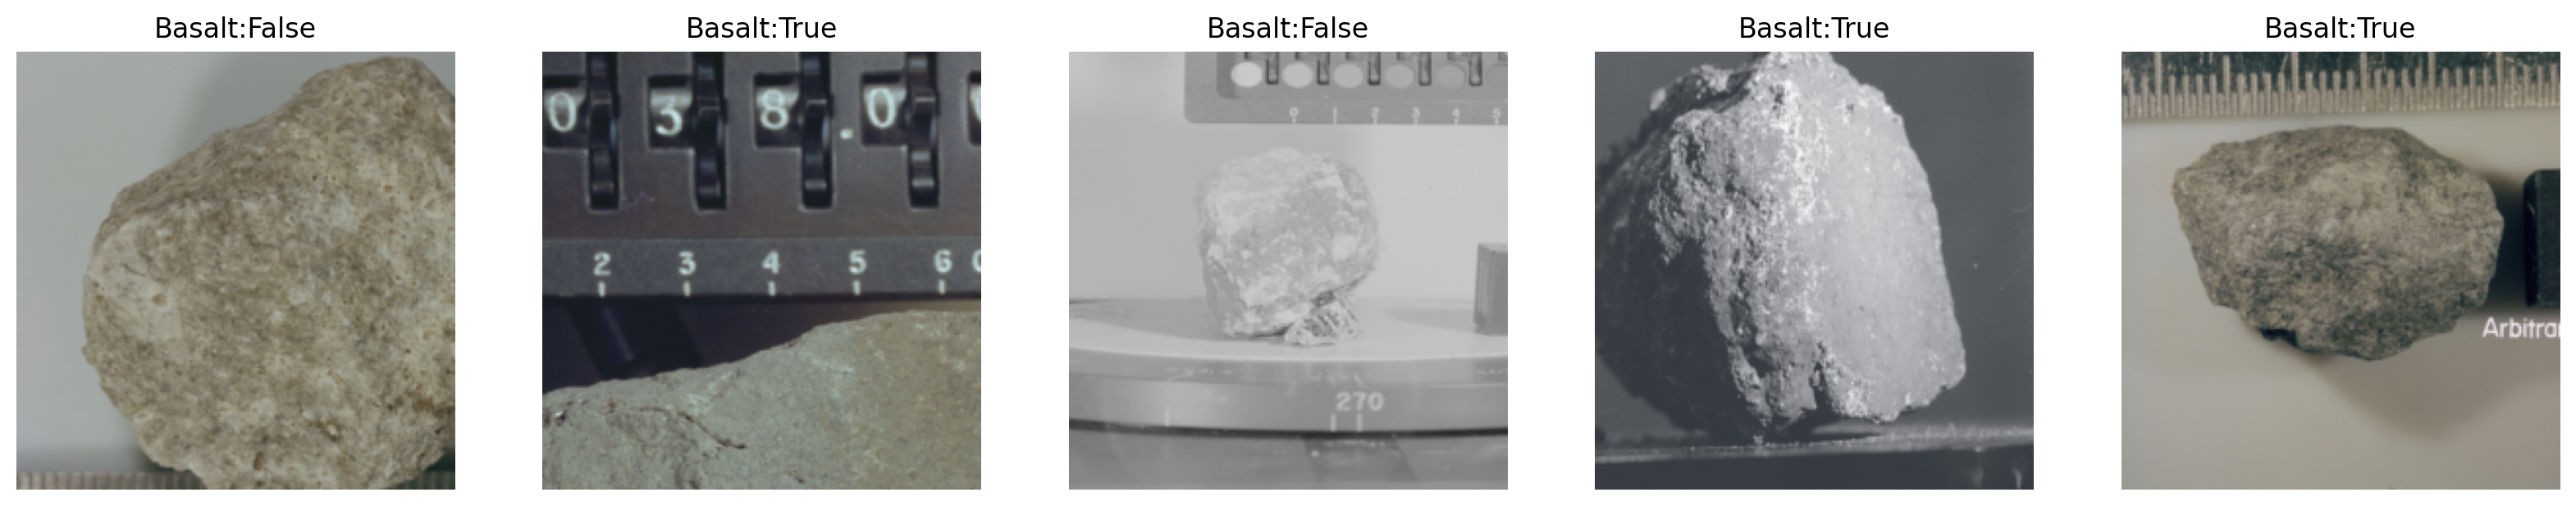

In [80]:
# Get five random images and display them in a figure with their labels
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))

# Load all of the classes from the training loader
classes=trainloader.dataset.classes

# Loop through the 5 randomly selected images
for ii in range(len(images)):

    # Predict the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    # Add the class to the plot graph to display beneath the image
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

# Reshow the plot with the predicted labels beneath the images
plt.show()


with 10 images

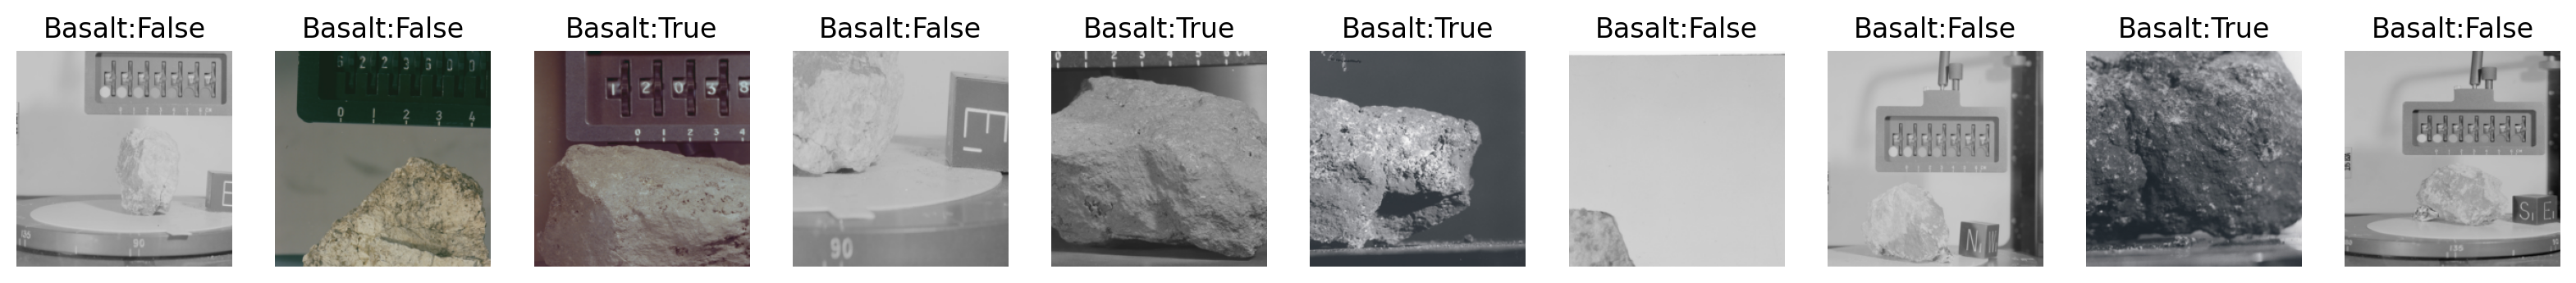

In [81]:
# Get five random images and display them in a figure with their labels
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig=plt.figure(figsize=(20,10))

# Load all of the classes from the training loader
classes=trainloader.dataset.classes

# Loop through the 5 randomly selected images
for ii in range(len(images)):

    # Predict the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    # Add the class to the plot graph to display beneath the image
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

# Reshow the plot with the predicted labels beneath the images
plt.show()
